# **FANG Stock Analysis**

Note: A lot of the writing in this project is taken from the R forecasting analysis (https://github.com/jkclem/FANG-stock-prediction/blob/master/FANG.Rmd) I did on this topic, but with a different sample period. The point of this project is different because it focuses on interpreting the relationship, instead of predictive modeling. I also use passages of my project on oil prices and exchange rates (https://github.com/jkclem/On-Real-Oil-Prices-and-Dollar-Exchange-Rates) to explain concepts like Granger causality and Johansen's Trace Test for cointegration.

If you have already read the R version, skip to the final section to learn about interpreting an VECM.

## **I. Introduction**

Financial data is the best known resource for time series data. Records of stock prices have been meticulously recorded for over a century providing rich data sets. The stocks of the so-called 'FANG' companies, Facebook, Amazon, Netflix, and Google/Alphabet, have gotten a lot of attention for their impressive returns and the 'cool' factor of these high-tech companies. But are these stocks truly related to each other? Or is this an example of Wall Street marketing a bundle of unrelated goods (see BRICS)? It's also possible that the perception that they are related by investors is enough to cause their stocks to move together. Even if we can't tell why they move together if they do, we can at least determine if they move together.

To find out, I got data from Yahoo Finance for the closing prices of the FANG stocks going back 5 years. This means the data set lacks data for how these companies' stocks acted in a recession. Regardless, I proceeded with my analysis. I tested for degree of integration, Granger causality, and Johansen integration. Based on the results, I proceeded with vector error correction modeling (VECM), which is a technique for simultaneously estimating multiple time series with at least 1 cointegrated relationship.

In [71]:
# imports datetime for picking beginning and end dates for the analysis
from datetime import datetime
# imports the get_historical_data from iexfinance to get historical data of stock prices
from iexfinance.stocks import get_historical_data
# imports pandas for dataframe manipulation
import pandas as pd

# this is my publishable token to use iexfinance
api_token = 'pk_684540ccf2b442eea739886789f36f68'

# sets the sample period as 5 years back from today (09/09/2019)
start = datetime(2014, 1, 1)
end = datetime(2019, 9, 9)

# gets the daily opening, high, low, and closing price data for facebook, amazon, netflix,
# and google, as well as trading volume and stores it as a pandas dataframe
fb = get_historical_data('FB', start, end, output_format = 'pandas', token = api_token)
amzn = get_historical_data('AMZN', start, end, output_format = 'pandas', token = api_token)
nflx = get_historical_data('NFLX', start, end, output_format = 'pandas', token = api_token)
googl = get_historical_data('GOOGL', start, end, output_format = 'pandas', token = api_token)

# merges the data sets two at a time and then all together into one dataframe
fa = pd.merge(left = fb, right = amzn, left_index = True, right_index = True, 
              suffixes = ('_fb', '_amzn'))
ng = pd.merge(left = nflx, right = googl, left_index = True, right_index = True, 
              suffixes = ('_nflx', '_googl'))
fang = pd.merge(left = fa, right = ng, left_index = True, right_index = True)

# creates a list of the columns containing closing prices for column selection
closing = ['close_fb', 'close_amzn', 'close_nflx', 'close_googl']

## **II. Data Properties**

Stationarity is where the mean an variance of a time series is not dependent on time. When graphed, it looks like white noise. Due to several problems caused by modeling non-stationary time series, chiefly autocorrelation, you need to check if a time-series is stationary prior to modeling. If it is not stationary, you need to get it there through differencing.

A glance at the graph above shows 4 time series that definitely look non-stationary. However, we need to formally test for it before proceeding.

> ### A. Auto-Correlation Function Analysis of Non-Differenced Variables 

The plots of the Auto-Correlation Functions (ACFs) of the non-differenced variables show that stocks are definitely not stationary. 

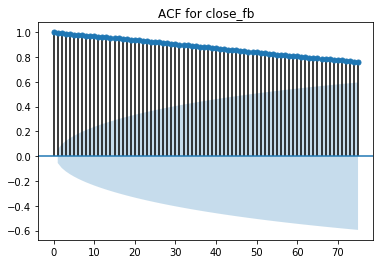

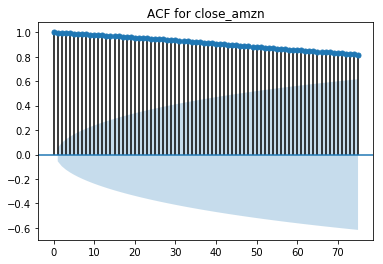

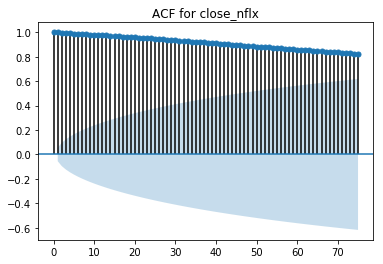

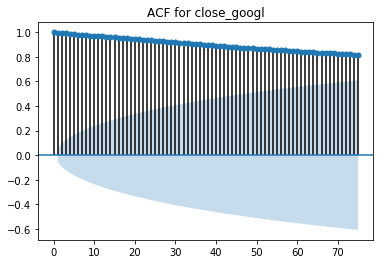

In [72]:
# imports pyplot from matplotlib for plotting functionality
from matplotlib import pyplot
# imports the auto-correlation graphic function
from statsmodels.graphics.tsaplots import plot_acf

# plots the autocorrelation plots for each stock's closing price at 75 lags
for i in closing:
    plot_acf(fang[i], lags = 75)
    pyplot.title('ACF for %s' % i) 
    pyplot.show()

> ### B. Auto-Correlation Function Analysis of Differenced Variables 

The ACFs of the differenced variables look potentially stationary. This suggests each stock is integrated I(1). Augmented Dickey-Fuller (ADF) tests can confirm this.

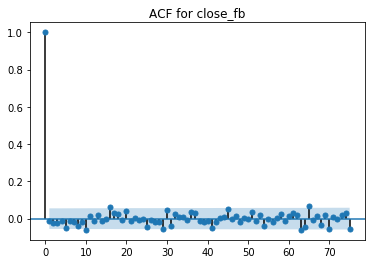

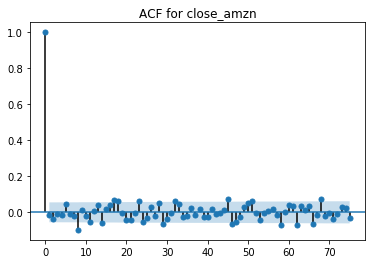

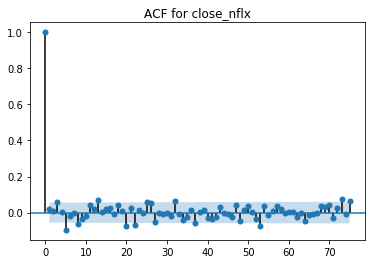

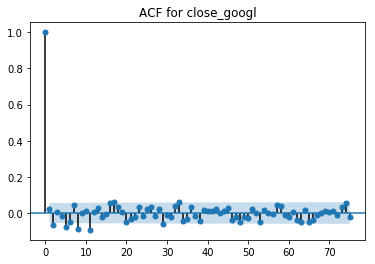

In [38]:
# plots the autocorrelation plots for the difference in each stock's closing price from the
# closing price the previous trading day at 75 lags
for i in closing:
    plot_acf(fang[i].diff().dropna(), lags = 75)
    pyplot.title('ACF for %s' % i) 
    pyplot.show()

> ### C. Augmented Dickey-Fuller Test for Non-Differenced Variables 

The null hypothesis is the data are non-stationary, so we want low p-values to tell us our data are stationary. That is not what the ADF tests for the non-differenced stock prices are telling us.

In [40]:
# imports the Augmented Dickey-Fuller Test for establishing the order of integration of 
# time series
from statsmodels.tsa.stattools import adfuller

# performs the Augmented Dickey-Fuller Test for all our variables of interest without
# a constant, with a constant, and with a constant and linear trend
for i in closing:
    for j in ['nc', 'c', 'ct']:
        result = adfuller(fang[i], regression = j)
        print('ADF Statistic with %s for %s: %f' % (j, i, result[0]))
        print('p-value: %f' % result[1])

ADF Statistic with nc for close_fb: 0.765443
p-value: 0.878929
ADF Statistic with c for close_fb: -1.292637
p-value: 0.632534
ADF Statistic with ct for close_fb: -2.991915
p-value: 0.134355
ADF Statistic with nc for close_amzn: 1.668146
p-value: 0.977201
ADF Statistic with c for close_amzn: -0.459704
p-value: 0.899643
ADF Statistic with ct for close_amzn: -2.567490
p-value: 0.295080
ADF Statistic with nc for close_nflx: 0.514656
p-value: 0.828223
ADF Statistic with c for close_nflx: -0.961462
p-value: 0.767060
ADF Statistic with ct for close_nflx: -2.115809
p-value: 0.537234
ADF Statistic with nc for close_googl: 1.511178
p-value: 0.967684
ADF Statistic with c for close_googl: -0.673303
p-value: 0.853544
ADF Statistic with ct for close_googl: -3.124246
p-value: 0.100580


> ### D. Augmented Dickey-Fuller Test for Differenced Variables 

These ADF test results tell us the differenced stock prices are stationary, with extremely high statistical signficicance.

The output of the ADF tests for the non-differenced and differenced strongly support the hypothesis that the stocks are integrated I(1). These stock prices need to be differenced once prior to modeling. Many time series packages for integrated time series models do this automatically.

In [41]:
# performs the Augmented Dickey-Fuller Test for all our variables of interest without
# a constant, with a constant, and with a constant and linear trend
for i in closing:
    for j in ['nc', 'c', 'ct']:
        result = adfuller(fang[i].diff().dropna(), regression = j)
        print('ADF Statistic with %s for %s: %f' % (j, i, result[0]))
        print('p-value: %f' % result[1])

ADF Statistic with nc for close_fb: -35.738211
p-value: 0.000000
ADF Statistic with c for close_fb: -35.764079
p-value: 0.000000
ADF Statistic with ct for close_fb: -35.750236
p-value: 0.000000
ADF Statistic with nc for close_amzn: -6.979084
p-value: 0.000000
ADF Statistic with c for close_amzn: -7.344412
p-value: 0.000000
ADF Statistic with ct for close_amzn: -7.344396
p-value: 0.000000
ADF Statistic with nc for close_nflx: -16.612081
p-value: 0.000000
ADF Statistic with c for close_nflx: -16.655543
p-value: 0.000000
ADF Statistic with ct for close_nflx: -16.649649
p-value: 0.000000
ADF Statistic with nc for close_googl: -13.070085
p-value: 0.000000
ADF Statistic with c for close_googl: -13.194410
p-value: 0.000000
ADF Statistic with ct for close_googl: -13.189680
p-value: 0.000000


## **III. Granger Causality**

Establishing causality in observational data is notoriously difficult. Granger causality is a lower bar. It simply says that if previous values of X can predict future values of y, then X Granger causes y. It is performed by estimating the regression of the lagged values of X on y and performing an F-test. If the p-value is small enough, you reject the null hypothesis that all the coefficients of the lagged values of X are 0. In plain English, small p-values say that the lagged Xs have predictive power on future y, with a corresponding level of confidence.

The output below says the closing price of FB has predictive power on the closing price of AMZN at the p = 0.10 significance level, NFLX on AMZN at the p = 0.05 significance level, and FB on GOOGL at the p = 0.01 significance level. Given the results of multi-directional Grange causality, VEC modeling seems a plausible choice.

In [73]:
# imports the permutation function to generate all permutations of 2 of the FANG stocks
from itertools import permutations
# imports test for Granger Causality (does variable x have value in predicting y)
from statsmodels.tsa.stattools import grangercausalitytests

# creates a list of tuples containing the permutations of length 2 of the FANG stocks
stock_perms = list(permutations(closing, 2))

# loops through the list of stock permutations
for i in range(len(stock_perms)):
    # converts the tuple to a list so it can be passed to the dataframe for column selection
    temp_list = list(stock_perms[i])
    # creates a temporary dataframe of just the two variables
    temp_df = fang[temp_list]
    # prints which permutation is being tested for interpretability
    print('Does a lag of ' + temp_list[1] + ' predict ' + temp_list[0])
    # prints the results of a Granger Causality test for each permutation with 1 lage
    print(grangercausalitytests(temp_df, maxlag = 1, addconst = True, verbose = True))
    # leaves two spaces for readability
    print('')
    print('')

Does a lag of close_amzn predict close_fb

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1101  , p=0.7401  , df_denom=1255, df_num=1
ssr based chi2 test:   chi2=0.1104  , p=0.7397  , df=1
likelihood ratio test: chi2=0.1104  , p=0.7397  , df=1
parameter F test:         F=0.1101  , p=0.7401  , df_denom=1255, df_num=1
{1: ({'ssr_ftest': (0.11009343637925316, 0.7400931865755154, 1255.0, 1), 'ssr_chi2test': (0.11035660794031908, 0.7397385074816105, 1), 'lrtest': (0.11035176776931621, 0.7397440081220136, 1), 'params_ftest': (0.11009343637958244, 0.74009318657504, 1255.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000020B02CDB7F0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000020B022D6518>, array([[0., 1., 0.]])])}


Does a lag of close_nflx predict close_fb

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5073  , p=0.4765  , df_denom=1255, df_num=1
ssr based chi2 t

## **IV. Johansen Cointegration**

For VEC modeling to be appropriate to model these stocks, Π (the vector of loading coefficients times the vector of error-correction coefficients that constitutes the error correction term in a VECM) times the column vector of dependent variables must be ~I(0) because all other terms on the right and left of the equation are ~I(0). For this to be true, Πx ⃑ = 0 must be true, where x ⃑ is a column vector of the dependent variables because change is 0 in equilibrium and there is equilibrium in the long-run. If the rank of Π is 0, then Π is the null matrix. If the rank is equal to the number of dependent variables, then x ⃑ = 0 must equal zero for the relationship to hold. In either case, there are no cointegrating vectors and there is no long-run relationship between the variables. If the rank of Π is greater than 0 and less than the number of dependent variables, there is a cointegrated relationship between the variables.

I used Johansen's Trace Test to establish cointegration. The null hypothesis is the rank of matrix Π is i and the alternative hypothesis is the rank of Π is equal to k, the number of endogenous variables, where i starts at 0 and proceeds sequentially to k.

The results of this test are that there is 1 cointegrating relationship between the FANG stocks at 1, 3, and 4 lags during the sample period at the 95% significance level. VEC modeling is appropriate to modeling these stocks.

In [84]:
# imports the coint_johansen function to test for cointegration as a prerequisite for VEC 
# modeling
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# uses https://nbviewer.jupyter.org/github/mapsa/seminario-doc-2014/blob/master/cointegration-
# example.ipynb to create functions to return the number of cointegrating vectors based 
# on the Trace version if the Johansen Cointegration Test
def johansen_trace(y, p):
        N, l = y.shape
        joh_trace = coint_johansen(y, 0, p)
        r = 0
        for i in range(l):
            if joh_trace.lr1[i] > joh_trace.cvt[i, 1]:     # 0: 90%  1:95% 2: 99%
                r = i + 1
        joh_trace.r = r

        return joh_trace

# loops through 1 to 10 lags of trading days trading days
for i in range(1, 11): 
    # tests for cointegration at i lags
    joh_trace = johansen_trace(fang[closing], i)
    # prints the results
    print('Using the Trace Test, there are', joh_trace.r, '''cointegrating vectors at 
    %s lags between the FANG stocks''' % i)
    # prints a space for readability
    print()

Using the Trace Test, there are 1 cointegrating vectors at 
    1 lags between the FANG stocks

Using the Trace Test, there are 0 cointegrating vectors at 
    2 lags between the FANG stocks

Using the Trace Test, there are 1 cointegrating vectors at 
    3 lags between the FANG stocks

Using the Trace Test, there are 1 cointegrating vectors at 
    4 lags between the FANG stocks

Using the Trace Test, there are 0 cointegrating vectors at 
    5 lags between the FANG stocks

Using the Trace Test, there are 0 cointegrating vectors at 
    6 lags between the FANG stocks

Using the Trace Test, there are 0 cointegrating vectors at 
    7 lags between the FANG stocks

Using the Trace Test, there are 0 cointegrating vectors at 
    8 lags between the FANG stocks

Using the Trace Test, there are 0 cointegrating vectors at 
    9 lags between the FANG stocks

Using the Trace Test, there are 0 cointegrating vectors at 
    10 lags between the FANG stocks



## **V. VECM Estimation and Analysis**

The loading coefficients (alphas) are the speed of adjustment to the long-run relationship. They are the percentage of disequilibrium from the long-run equilibrium that disapates in one period. The alphas for the closing price of FB and NFLX are not statistically significant. The significance of the alpha for AMZN is ambiguous as it is significant at the 0.10 significance level, but not the 0.05 significance level. The alpha for GOOGL is statistically significant at the 0.05 significance level and estimated at 0.0529. 

This information means FB and NFLX (and possibly AMZN) are weakly exogenous to GOOGL (and possibly AMZN). Weak exogeneity is the concept that deviations from the long-run do not directly affect the weakly exogenous variable. The effect comes from the subsequent lags from the non-weakly exogenous variables. The lags of GOOGL (and possibly AMZN) are the drivers of the return to the long-run equilibrium in the weakly exogenous variables.

The beta coefficients are the actual long-run relationship coefficients. The beta for FB is standardized at 1 for ease of interpretation of the other beta coefficients. The beta for GOOGL is -0.4204, which means a 1 dollar increase in GOOGL, leads to a 0.4204 dollar decrease in the closing price of FB in the long-run and 5.29% of this correction occurs within a day. Rearranging which beta is standardized is how you tell how the other stocks affect the stock with the standardized beta.

In [85]:
# imports VECM for VECM modeling
from statsmodels.tsa.vector_ar.vecm import VECM

# estimates the VECM on the closing prices with 4 lags, 1 cointegrating relationship, and
# a constant within the cointegration relationship
fang_vecm = VECM(endog = fang[closing], k_ar_diff = 4, coint_rank = 1, deterministic = 'ci')
fang_vecm_fit = fang_vecm.fit()
fang_vecm_fit.summary()

C:\Users\jkcle\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,coef,std err,z,P>|z|,[0.025,0.975]
L1.close_fb,0.0211,0.036,0.580,0.562,-0.050,0.092
L1.close_amzn,-0.0104,0.005,-1.998,0.046,-0.021,-0.000
L1.close_nflx,-0.0174,0.018,-0.986,0.324,-0.052,0.017
L1.close_googl,0.0103,0.008,1.322,0.186,-0.005,0.025
L2.close_fb,0.0351,0.036,0.965,0.335,-0.036,0.107
L2.close_amzn,0.0021,0.005,0.406,0.685,-0.008,0.012
L2.close_nflx,0.0218,0.018,1.236,0.217,-0.013,0.056
L2.close_googl,-0.0283,0.008,-3.640,0.000,-0.044,-0.013
L3.close_fb,-0.0189,0.037,-0.517,0.605,-0.091,0.053
L3.close_amzn,-0.0049,0.005,-0.939,0.348,-0.015,0.005


Impulse Response Functions (IRF) show what happens to one variable when you shock another (or the same variable) with an increase of 1 in the previous period. The blue curve shows the effect of the unit shock as the shock becomes less and less recent. The dotted lines represent the 95% confidence interval for the IRF.

A 1 dollar shock to the closing price of GOOGL leads to a drop in the closing price of FB, but the effect of that shock goes to zero over time. The effect of a 1 dollar shock to NFLX initially increases GOOGL's closing price by about 5 cents, but then goes to approximately zero. A unit shock to FB however, persists as do some others like NFLX on AMZN. If all the IRFs were like those, the system would be dynamically unstable, but luckily 0 is within the 95% confidence level of many of our IRFs.

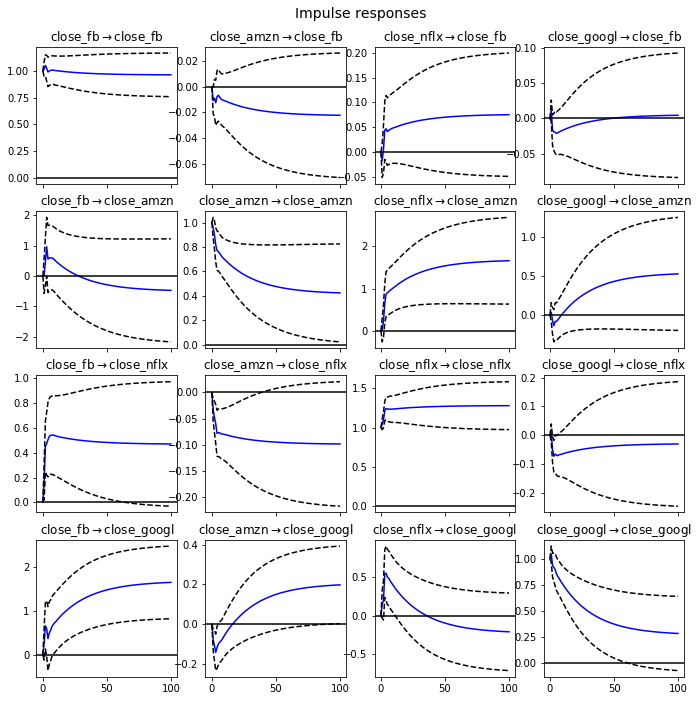

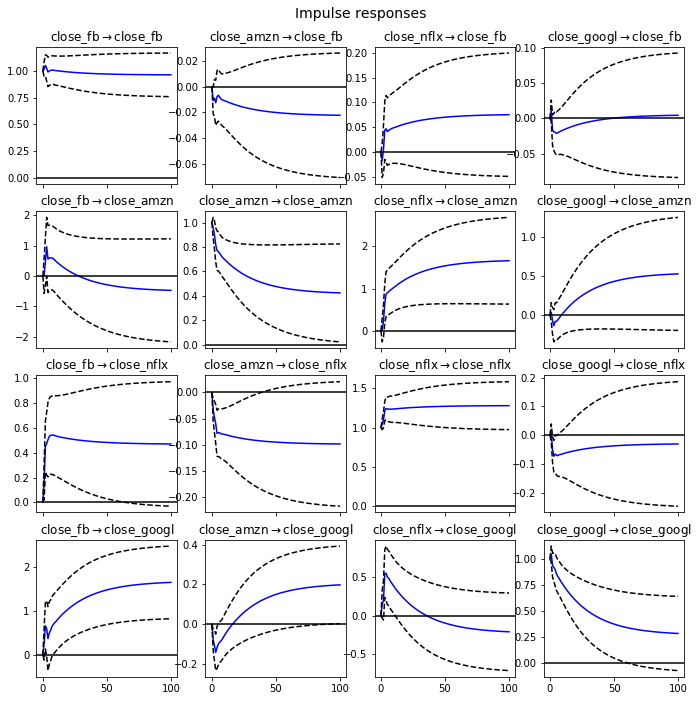

In [101]:
# stores and prints the impulse response functions
irf = fang_vecm_fit.irf(100)
irf.plot(orth = False)

Below is just a graph of the closing stock prices with dynamic forecasting out roughly half a year with error bands.

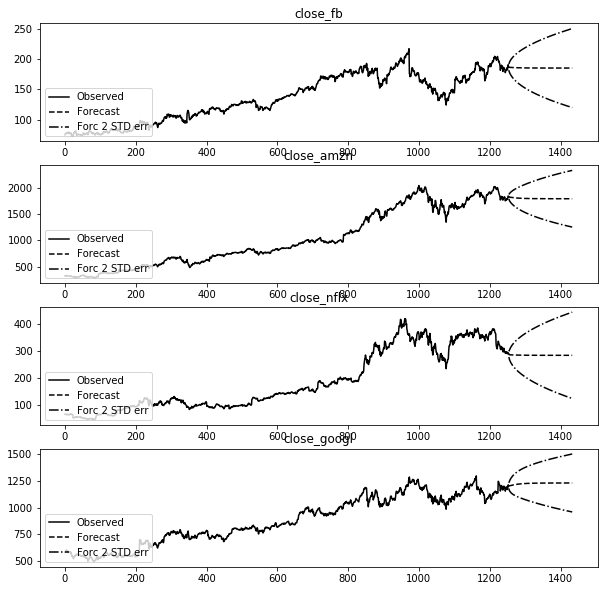

In [99]:
# plots the dynamic forecasts of the FANG stocks out to about half a year (mainly for visual
# purposes)
fang_vecm_fit.plot_forecast(180)